# Imports

In [1]:
# import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neural_network import MLPClassifier as MLP

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import np_utils

import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

# Funciones de ayuda

In [4]:
def classifier(x : np.array, y : np.array, cl : str="linear", k : int=5, knn : int=3, n_neurons : int=100, n_layers : int=3, iterations : int=1000, saveCLF : bool=False, nameCLF : str=None, verbose : bool=True):
    """
    Función que evalúa los el clasificador seleccionado 'cl' con los datos seleccionados.
    Imprime a consola el accuracy general y recall por clase con kfold y
    el accuracy y recall con cross-validation generales para el modelo clasificador.

    Parámetros
    ----------
    x : np.array
        Matriz con vectores de entrada para el clasificador.
    
    y : np.array
        Arreglo con las etiquetas correspondientes de cada vector en la matriz x.

    cl : str ["linear", "rbf", "knn", "tree", "NN"] - default linear
        El modelo del clasificador a usar

    k : int - default 5
        Número de splits a realizar por la validación cruzada.
    
    knn : int - default 3
        Si cl = knn, este representa la cantidad de vecinos.

    n_neurons : int - default 100
        Si cl = NN, establece el número de neuronas por capa para la red neuronal.

    n_layers : int - default 3
        Si cl = NN, establece el número de capas internas de la red neuronal.

    iterations : int - default 1000
        Si cl = NN, establece el número máximo de iteraciones para converger de la red neuronal.

    saveCLF : bool - default False
        Establece si quieres guardar el modelo clasificador dentro de un archivo serializado.
        El archivo se guardará en la carpeta donde se encuentre este script.
    
    nameCLF : str - default None
        Si saveCLF = True, establece el nombre del archivo en el cual se guardará el modelo clasificador.
        Si se deja como None, el nombre será el tipo del clasificador + str("Classifier.clf").
    
    verbose : bool - default True
        True para que la salida a consola describa más al clasificador, su recall y exactitud y recall con cross-validate.

    Regresa
    -------
    clf : sklearn.classifier
        Regresa el objeto del modelo clasificador de la librería sklearn.
    """

    kf = StratifiedKFold(n_splits=k, shuffle = True)
    clf = None

    if cl == "knn":
        clf = KNC(n_neighbors=knn)
    elif cl == "tree":
        clf = DTC()
    elif cl == "NN":
        layers = tuple([n_neurons for _ in range(n_layers)])
        clf = MLP(hidden_layer_sizes=layers, max_iter=iterations)
    elif cl == "linear" or cl == "rbf":
        clf = svm.SVC(kernel = cl)
    else:
        print("Porfavor selecciona un modelo dentro de las opciones\n")
        return -1

    if verbose:
        print("----------------------------------------------------------------")
        print(f"Clasificador {cl}")
        if cl == "knn":
            print(f"k = {knn}")
        elif cl == "NN":
            print(f"Neuronas = {n_neurons}\nCapas = {n_layers}")
        print()

    acc = 0

    recall = np.array([0.,0.,0.,0.,0.,0.])
    for train_index, test_index in kf.split(x, y):
        
        # Training phase
        x_train = x[train_index, :]
        y_train = y[train_index]
        clf.fit(x_train, y_train)

        # Test phase
        x_test = x[test_index, :]
        y_test = y[test_index]    
        y_pred = clf.predict(x_test)

        # Calculate confusion matrix and model performance
        cm = confusion_matrix(y_test, y_pred)
        # print('Confusion matrix\n', cm)
        
        acc += (cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5])/len(y_test)
        recall[0] += cm[0,0]/(cm[0,0] + cm[0,1] + cm[0,2] + cm[0,3] + cm[0,4] + cm[0,5])
        recall[1] += cm[1,1]/(cm[1,0] + cm[1,1] + cm[1,2] + cm[1,3] + cm[1,4] + cm[1,5])
        recall[2] += cm[2,2]/(cm[2,0] + cm[2,1] + cm[2,2] + cm[2,3] + cm[2,4] + cm[2,5])
        recall[3] += cm[3,3]/(cm[3,0] + cm[3,1] + cm[3,2] + cm[3,3] + cm[3,4] + cm[3,5])
        recall[4] += cm[4,4]/(cm[4,0] + cm[4,1] + cm[4,2] + cm[4,3] + cm[4,4] + cm[4,5])
        recall[5] += cm[5,5]/(cm[5,0] + cm[5,1] + cm[5,2] + cm[5,3] + cm[5,4] + cm[5,5])

    # Print results
    acc = acc/k
    recall = recall/k
    print('Kfold\nAcc: ', acc)
    print('Recall: ', recall)

    if verbose:
        # 5-fold cross-validation using cross_validate
        cv_results = cross_validate(clf, x, y, cv=k, scoring = ('accuracy', 'recall_micro'))
        print("\nCross Validation")
        print('Acc: ', cv_results['test_accuracy'].sum()/k)
        print('Recall: ', cv_results['test_recall_micro'].sum()/k)
        print("----------------------------------------------------------------\n")

    if saveCLF:
        if nameCLF == None:
            with open(cl + "Classifier.clf", "wb") as CLFfile:
                pickle.dump(clf, CLFfile)
        else:
            with open(nameCLF + ".clf", "wb") as CLFfile:
                pickle.dump(clf, CLFfile)

    return clf

In [44]:
def cnn(x, y, splits=5, img_rows=72, img_cols=128, num_classes=6, epocas=50):
    """
    Función que evalúa una red neuronal convolusional con las imágenes en escala de grises.

    Parámetros
    ----------
    x : np.array
        Matriz con vectores de entrada para la CNN.
    
    y : np.array
        Arreglo con las etiquetas correspondientes de cada vector en la matriz x.

    splits : int - default 5
        Número de splits a realizar por la validación cruzada.

    img_rows : int - default 72
        Filas correspondientes de las imágenes.

    img_cols : int - default 128
        Columnas correspondientes de las imágenes.
    
    num_clases : int - default 6
        Número de etiquetas objetivo

    epocas = int - default 50
        Número de épocas para la CNN.
        Mientras más épocas, la CNN estará mejor entrenada
    """

    kf = KFold(n_splits=splits, shuffle = True)

    for train_index, test_index in kf.split(x):
        
        x_train = x[train_index, :]
        y_train = y[train_index]

        x_test = x[test_index, :]
        y_test = y[test_index]

    # Prepare data for CNN
    if K.image_data_format() == 'channels_first':
        x = x_train.reshape(x.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x = x.reshape(x.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    x = x.astype('float32')
    y = y - 1

    # Cross-validation
    kf = KFold(n_splits=splits, shuffle = True)

    acc = 0
    recall = np.array([0., 0., 0., 0., 0., 0.])
    k = 0
    for train_index, test_index in kf.split(x):
        k = k + 1
        print('***** Fold:', k, '*****')

        # Define CNN model
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy', optimizer='Adadelta')

        # Fit model
        x_train = x[train_index, :, :, :]
        y_train = y[train_index]
        y_train = np_utils.to_categorical(y_train, num_classes)

        model.fit(x_train, y_train, epochs=epocas, batch_size=8, verbose=1)

        # Evaluate model using test data
        x_test = x[test_index, :, :, :]
        y_test = y[test_index]

        y_pred = np.argmax(model.predict(x_test), axis=-1)

        cm = confusion_matrix(y_test, y_pred)
        acc += (cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5])/len(y_test)
        recall[0] += cm[0,0]/(cm[0,0] + cm[0,1] + cm[0,2] + cm[0,3] + cm[0,4] + cm[0,5])
        recall[1] += cm[1,1]/(cm[1,0] + cm[1,1] + cm[1,2] + cm[1,3] + cm[1,4] + cm[1,5])
        recall[2] += cm[2,2]/(cm[2,0] + cm[2,1] + cm[2,2] + cm[2,3] + cm[2,4] + cm[2,5])
        recall[3] += cm[3,3]/(cm[3,0] + cm[3,1] + cm[3,2] + cm[3,3] + cm[3,4] + cm[3,5])
        recall[4] += cm[4,4]/(cm[4,0] + cm[4,1] + cm[4,2] + cm[4,3] + cm[4,4] + cm[4,5])
        recall[5] += cm[5,5]/(cm[5,0] + cm[5,1] + cm[5,2] + cm[5,3] + cm[5,4] + cm[5,5])

        print(acc/k, recall/k)


    acc/=splits
    recall = recall/splits
    print('CNN: ', acc, recall)

# Carga de datos para clasificadores

In [9]:
file = "images_descriptors.obj"
descriptors_dict = dict()
biomas_id = {"Agua":0, "Bosque":1, "Ciudad":2, "Cultivo":3, "Desierto":4, "Montaña":5}

with open(os.path.join(os.getcwd(), file), "rb") as file:
    descriptors_dict = pickle.load(file)

lista_llaves = sorted(list(descriptors_dict.keys()))
y = np.array([biomas_id.get(etiqueta.split("_")[0]) for etiqueta in lista_llaves])
x = np.array([descriptors_dict.get(bioma) for bioma in lista_llaves])

# Guardar clasificador en archivo serializado

In [18]:
clf = classifier(x, y, cl="NN", n_layers=1, iterations=3000)
# print(clf)

with open("MLPClassifier.clf", "wb") as file:
    pickle.dump(clf, file)
    print(clf, "saved")

----------------------------------------------------------------
Clasificador NN
Neuronas = 100
Capas = 1

Kfold
Acc:  0.5811414392059554
Recall:  [0.81750339 0.70746269 0.78871817 0.36232474 0.08380823 0.72250639]

Cross Validation
Acc:  0.5533498759305211
Recall:  0.5533498759305211
----------------------------------------------------------------

MLPClassifier(max_iter=3000) saved


# Clasificación con validación cruzada

In [5]:
classifier(x, y, cl="linear")
classifier(x, y, cl="rbf")
classifier(x, y, cl="knn", k=5)
classifier(x, y, cl="tree")
classifier(x, y, cl="NN", n_neurons=100)

NameError: name 'classifier' is not defined

# Carga de datos para CNN

In [40]:
img_rows, img_cols = 72, 128
file = "images_gray.obj"
images_dict = dict()
biomas_id = {"Agua":0, "Bosque":1, "Ciudad":2, "Cultivo":3, "Desierto":4, "Montaña":5}

with open(os.path.join(os.getcwd(), file), "rb") as file:
    images_dict = pickle.load(file)

lista_llaves = sorted(list(images_dict.keys()))
y = np.array([biomas_id.get(etiqueta.split("_")[0]) for etiqueta in lista_llaves])
x = np.array([images_dict.get(bioma) for bioma in lista_llaves])

## Imagen de prueba

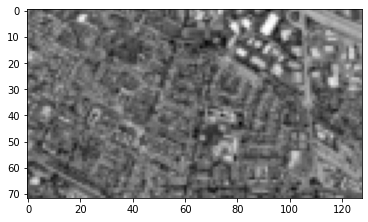

In [38]:
# Cargar la imagen 'num' 
num = 1000
ex = x[num,:]
ex = ex.reshape(img_rows, img_cols)
plt.imshow(ex, cmap='gray')
plt.show()

# Redes neuronales convolucionales

In [45]:
cnn(x, y, epocas=10)

***** Fold: 1 *****
Epoch 1/10
202/202 [==============================] - 47s 233ms/step - loss: 12.1928
Epoch 2/10
202/202 [==============================] - 38s 190ms/step - loss: 3.1890
Epoch 3/10
202/202 [==============================] - 39s 192ms/step - loss: 2.1611
Epoch 4/10
202/202 [==============================] - 37s 185ms/step - loss: 1.9967
Epoch 5/10
202/202 [==============================] - 37s 183ms/step - loss: 1.8937
Epoch 6/10
202/202 [==============================] - 37s 183ms/step - loss: 1.8963
Epoch 7/10
202/202 [==============================] - 40s 196ms/step - loss: 1.8792
Epoch 8/10
202/202 [==============================] - 38s 186ms/step - loss: 1.8671
Epoch 9/10
202/202 [==============================] - 39s 193ms/step - loss: 1.8521
Epoch 10/10
13/13 [==============================] - 3s 67ms/step
0.1761786600496278 [0.         0.98571429 0.         0.02941176 0.         0.        ]
***** Fold: 2 *****
Epoch 1/10
202/202 [==============================

# Preguntas

#### ¿Consideran que el mejor clasificador obtenido es efectivo en la identificación de biomas?
    No, ya que tiene un accuracy de menos del 60%
#### ¿Qué estrategia funciona mejor, una CNN sin técnicas de procesamiento y extracción de características, o los modelos clásicos?
    Los modelos clásicos funcionan mejor mientras que la CNN use pocas épocas
#### ¿Qué mejoras harían para aumentar la precisión de sus modelos?
    Aumentar la cantidad de descriptores por vector dentro de la matriz de características